In [4]:
%matplotlib inline
import autograd.numpy as np
from autograd.numpy.linalg import inv, det
from autograd import grad
from functools import reduce
import autograd.numpy.random as npr
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, gamma, invgamma 
from scipy.special import digamma, polygamma
from scipy.special import gamma as gafun
from pykalman import KalmanFilter
from util import *
from kalman import *

In [2]:
# num_sequences = 50
# time_length = 100
# image_length = 20
# generate_dataset_filename = './bouncingball'
# dataset_filename = './bouncingball.npy'

## Load Dataset

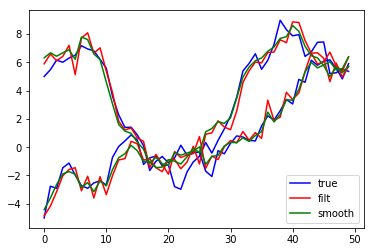

In [41]:
# ## generate dataset
# # video_arrays = generate_dataset(generate_dataset_filename, num_sequences, image_length, time_length)
# train_dataset = load_data(dataset_filename, num_sequences, image_length, time_length)
# ## just take one video
# video = train_dataset[0, :, :]
# specify parameters
random_state = np.random.RandomState(0)
transition_matrix = [[1, 0.1], [0, 1]]
transition_offset = [0, 0]
observation_matrix = np.eye(2)
observation_offset = [0, 0]
transition_covariance = np.eye(2)
observation_covariance = np.eye(2) 
initial_state_mean = [5, -5]
initial_state_covariance = [[1, 0.1], [-0.1, 1]]

# sample from model
kf = KalmanFilter(
    transition_matrix, observation_matrix, transition_covariance,
    observation_covariance, transition_offset, observation_offset,
    initial_state_mean, initial_state_covariance,
    random_state=random_state
)
states, observations = kf.sample(
    n_timesteps=50,
    initial_state=initial_state_mean
)

# estimate state with filtering and smoothing
filtered_state_estimates = kf.filter(observations)[0]
smoothed_state_estimates = kf.smooth(observations)[0]

# draw estimates
plt.figure()
lines_true = plt.plot(states, color='b')
lines_filt = plt.plot(filtered_state_estimates, color='r')
lines_smooth = plt.plot(smoothed_state_estimates, color='g')
plt.legend((lines_true[0], lines_filt[0], lines_smooth[0]),
          ('true', 'filt', 'smooth'),
          loc='lower right'
)
plt.show()

In [42]:
video = np.array(observations).T

## Hyper-parameters

In [43]:
N = 2
T = 50
K = 2

# initialize hyperpriors
alpha_a_0, alpha_b_0, r_a_0, r_b_0, mu_x0_0_sigma_diag, sigma_x0_a, sigma_x0_b = init_hyper(K)
rhos = np.ones(N) ## rhos is constant !!!
## sample hyper parameters, hidden state priors
alpha = gamma.rvs(a=alpha_a_0, scale=(1.0 / alpha_b_0))
r = gamma.rvs(a=r_a_0, scale=(1.0 / r_b_0))

# mu_x0 = multivariate_normal.rvs(np.zeros(K), np.diag(mu_x0_0_sigma_diag))
# mu_x0.shape = (K, 1)
# sigma_x0 = 1.0 / gamma.rvs(a=sigma_x0_a, scale=(1.0 / sigma_x0_b))
# sigma_x0 = np.diag(sigma_x0)
mu_x0 = np.array(initial_state_mean)
mu_x0.shape = (K, 1)
sigma_x0 = np.array(initial_state_covariance)
Y_hat = compute_yhat(video, N, T)

# q_sigma_A, q_mu_A, sigma_C, q_mu_C = init_qs(alpha, r, N, T, K)
W_A, S_A, W_C, S_C = init_hsss(mu_x0, video, N, T, K)

## Training

In [44]:
Epoch = 200
ELBOs_list = []
kl_A_list = []
kl_C_list = []
kl_rho_list = []
log_Z_list = []
for epoch in range(Epoch):
    ## VBM step
    ## infer variational distributions
    q_sigma_A, q_mu_A, sigma_C, q_mu_C = infer_qs(W_A, S_A, W_C, S_C, Y_hat, alpha, r, rhos, N, T)
    ## compute expected natural parameters
    E_A, E_ATA, E_R_inv, E_C, E_R_inv_C, E_CT_R_inv_C = natstats(rhos, S_A, S_C, q_sigma_A, sigma_C, N, K)
    natstats_list = [E_A, E_ATA, E_R_inv, E_C, E_R_inv_C, E_CT_R_inv_C]
    
    ## VBE step
    # forward recursion
    Mu_xt, Sigma_xt, Sigma_star, log_Z = forward(mu_x0, sigma_x0, N, T, K, video, *natstats_list)
    # backward recursion
    psi_T_inv = np.zeros((K, K))
    eta_T = np.ones((K, 1))
    Psi, Eta = backward(psi_T_inv, eta_T, video, N, T, K, *natstats_list)
    # update Gamma and Omega
    Gamma_ts, Omega_ts, Gamma_ttp1s = update_marginals(Mu_xt, Sigma_xt, Sigma_star, Psi, Eta, N, T, K, E_A, E_CT_R_inv_C)
    # update hsss
    W_A, S_A, W_C, S_C = update_hsss(Gamma_ts, Omega_ts, Gamma_ttp1s, video, N, T)
    
    ## update hyper-parameters
    alpha_new, r_new, mu_x0_new, sigma_x0_new = update_hyper(Gamma_ts, Omega_ts, S_A, S_C, q_sigma_A, sigma_C, E_R_inv, N)
    alpha = alpha_new
    r = r_new
    mu_x0 = mu_x0_new
    sigma_x0 = sigma_x0_new

    
    ## ELBO
    
    p_sigma_A = np.diag(1.0 / alpha)
    p_sigma_C = np.diag(1.0 / r)

    kl_A = KL_A(q_mu_A, q_sigma_A, p_sigma_A, K)
    kl_C = KL_C(q_mu_C, sigma_C, p_sigma_C, N)

  
    ELBO = - kl_A - kl_C + log_Z
    ELBOs_list.append(ELBO)
    kl_A_list.append(kl_A)
    kl_C_list.append(kl_C)
    log_Z_list.append(log_Z)
    print('EPOCH : %d, ELBO : %f, ' % ((epoch+1), ELBO))
#     print('kl_A : %f, kl_C : %f, kl_rho : %f, log_Z : %f' % (kl_A, kl_C, kl_rho, log_Z))

EPOCH : 1, ELBO : -1066.247996, 
EPOCH : 2, ELBO : -990.114129, 
EPOCH : 3, ELBO : -709.871698, 
EPOCH : 4, ELBO : -673.990382, 
EPOCH : 5, ELBO : -228.919367, 
EPOCH : 6, ELBO : -195.356238, 
EPOCH : 7, ELBO : -194.378298, 
EPOCH : 8, ELBO : -193.472946, 
EPOCH : 9, ELBO : -192.616403, 
EPOCH : 10, ELBO : -191.806262, 
EPOCH : 11, ELBO : -191.039859, 
EPOCH : 12, ELBO : -190.314659, 
EPOCH : 13, ELBO : -189.628272, 
EPOCH : 14, ELBO : -188.978442, 
EPOCH : 15, ELBO : -188.363047, 
EPOCH : 16, ELBO : -187.780092, 
EPOCH : 17, ELBO : -187.227699, 
EPOCH : 18, ELBO : -186.704108, 
EPOCH : 19, ELBO : -186.207666, 
EPOCH : 20, ELBO : -185.736822, 
EPOCH : 21, ELBO : -185.290123, 
EPOCH : 22, ELBO : -184.866203, 
EPOCH : 23, ELBO : -184.463785, 
EPOCH : 24, ELBO : -184.081670, 
EPOCH : 25, ELBO : -183.718732, 
EPOCH : 26, ELBO : -183.373919, 
EPOCH : 27, ELBO : -183.046239, 
EPOCH : 28, ELBO : -182.734765, 
EPOCH : 29, ELBO : -182.438625, 
EPOCH : 30, ELBO : -182.157001, 
EPOCH : 31, ELBO :

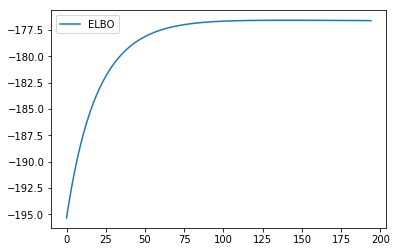

In [45]:
ax = plt.gca()
ax.plot(ELBOs_list[5:], label='ELBO')
# ax.plot(kl_A_list, label='kl_A')
# ax.plot(kl_C_list, label='kl_C')

# ax.plot(log_Z_list, label='log_Z')
ax.legend()

In [49]:
# forward recursion
Mu_xt, Sigma_xt, Sigma_star, log_Z = forward(mu_x0, sigma_x0, N, T, K, video, *natstats_list)
# backward recursion
psi_T_inv = np.zeros((K, K))
eta_T = np.ones((K, 1))
Psi, Eta = backward(psi_T_inv, eta_T, video, N, T, K, *natstats_list)
# update Gamma and Omega
Gamma_ts, Omega_ts, Gamma_ttp1s = update_marginals(Mu_xt, Sigma_xt, Sigma_star, Psi, Eta, N, T, K, E_A, E_CT_R_inv_C)

Mu_xt = np.squeeze(Mu_xt, -1)
Omega_ts = np.squeeze(Omega_ts, -1)
plt.figure()
lines_true = plt.plot(states, color='b')
lines_filt = plt.plot(Mu_xt, color='r')
lines_smooth = plt.plot(Omega_ts, color='g')
plt.legend((lines_true[0], lines_filt[0], lines_smooth[0]),
          ('true', 'filt', 'smooth'),
          loc='lower right'
)
plt.show()

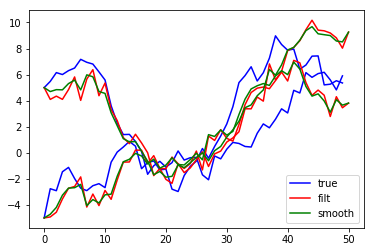

In [50]:
Mu_xt = np.squeeze(Mu_xt, -1)
Omega_ts = np.squeeze(Omega_ts, -1)
plt.figure()
lines_true = plt.plot(states, color='b')
lines_filt = plt.plot(Mu_xt, color='r')
lines_smooth = plt.plot(Omega_ts, color='g')
plt.legend((lines_true[0], lines_filt[0], lines_smooth[0]),
          ('true', 'filt', 'smooth'),
          loc='lower right'
)
plt.show()

In [52]:
Epoch = 1000
ELBOs_list = []
kl_A_list = []
kl_C_list = []
kl_rho_list = []
log_Z_list = []
for epoch in range(Epoch):
    ## VBM step
    ## infer variational distributions
    q_sigma_A, q_mu_A, sigma_C, q_mu_C = infer_qs(W_A, S_A, W_C, S_C, Y_hat, alpha, r, rhos, N, T)
    ## compute expected natural parameters
    E_A, E_ATA, E_R_inv, E_C, E_R_inv_C, E_CT_R_inv_C = natstats(rhos, S_A, S_C, q_sigma_A, sigma_C, N, K)
    natstats_list = [E_A, E_ATA, E_R_inv, E_C, E_R_inv_C, E_CT_R_inv_C]
    
    ## VBE step
    # forward recursion
    Mu_xt, Sigma_xt, Sigma_star, log_Z = forward(mu_x0, sigma_x0, N, T, K, video, *natstats_list)
    # backward recursion
    psi_T_inv = np.zeros((K, K))
    eta_T = np.ones((K, 1))
    Psi, Eta = backward(psi_T_inv, eta_T, video, N, T, K, *natstats_list)
    # update Gamma and Omega
    Gamma_ts, Omega_ts, Gamma_ttp1s = update_marginals(Mu_xt, Sigma_xt, Sigma_star, Psi, Eta, N, T, K, E_A, E_CT_R_inv_C)
    # update hsss
    W_A, S_A, W_C, S_C = update_hsss(Gamma_ts, Omega_ts, Gamma_ttp1s, video, N, T)
    
    ## update hyper-parameters
    alpha_new, r_new, mu_x0_new, sigma_x0_new = update_hyper(Gamma_ts, Omega_ts, S_A, S_C, q_sigma_A, sigma_C, E_R_inv, N)
    alpha = alpha_new
    r = r_new
    mu_x0 = mu_x0_new
    sigma_x0 = sigma_x0_new

    
    ## ELBO
    
    p_sigma_A = np.diag(1.0 / alpha)
    p_sigma_C = np.diag(1.0 / r)

    kl_A = KL_A(q_mu_A, q_sigma_A, p_sigma_A, K)
    kl_C = KL_C(q_mu_C, sigma_C, p_sigma_C, N)

  
    ELBO = - kl_A - kl_C + log_Z
    ELBOs_list.append(ELBO)
    kl_A_list.append(kl_A)
    kl_C_list.append(kl_C)
    log_Z_list.append(log_Z)
    print('EPOCH : %d, ELBO : %f, ' % ((epoch+1), ELBO))
#     print('kl_A : %f, kl_C : %f, kl_rho : %f, log_Z : %f' % (kl_A, kl_C, kl_rho, log_Z))

EPOCH : 1, ELBO : -177.130824, 
EPOCH : 2, ELBO : -177.130982, 
EPOCH : 3, ELBO : -177.131140, 
EPOCH : 4, ELBO : -177.131297, 
EPOCH : 5, ELBO : -177.131455, 
EPOCH : 6, ELBO : -177.131611, 
EPOCH : 7, ELBO : -177.131768, 
EPOCH : 8, ELBO : -177.131924, 
EPOCH : 9, ELBO : -177.132079, 
EPOCH : 10, ELBO : -177.132235, 
EPOCH : 11, ELBO : -177.132389, 
EPOCH : 12, ELBO : -177.132544, 
EPOCH : 13, ELBO : -177.132698, 
EPOCH : 14, ELBO : -177.132852, 
EPOCH : 15, ELBO : -177.133005, 
EPOCH : 16, ELBO : -177.133158, 
EPOCH : 17, ELBO : -177.133311, 
EPOCH : 18, ELBO : -177.133463, 
EPOCH : 19, ELBO : -177.133615, 
EPOCH : 20, ELBO : -177.133766, 
EPOCH : 21, ELBO : -177.133917, 
EPOCH : 22, ELBO : -177.134068, 
EPOCH : 23, ELBO : -177.134218, 
EPOCH : 24, ELBO : -177.134368, 
EPOCH : 25, ELBO : -177.134518, 
EPOCH : 26, ELBO : -177.134667, 
EPOCH : 27, ELBO : -177.134816, 
EPOCH : 28, ELBO : -177.134964, 
EPOCH : 29, ELBO : -177.135112, 
EPOCH : 30, ELBO : -177.135260, 
EPOCH : 31, ELBO : 

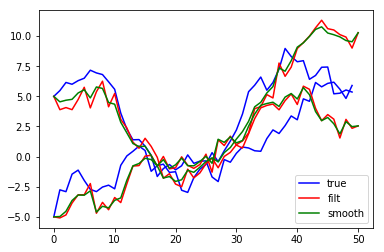

In [53]:
# forward recursion
Mu_xt, Sigma_xt, Sigma_star, log_Z = forward(mu_x0, sigma_x0, N, T, K, video, *natstats_list)
# backward recursion
psi_T_inv = np.zeros((K, K))
eta_T = np.ones((K, 1))
Psi, Eta = backward(psi_T_inv, eta_T, video, N, T, K, *natstats_list)
# update Gamma and Omega
Gamma_ts, Omega_ts, Gamma_ttp1s = update_marginals(Mu_xt, Sigma_xt, Sigma_star, Psi, Eta, N, T, K, E_A, E_CT_R_inv_C)

Mu_xt = np.squeeze(Mu_xt, -1)
Omega_ts = np.squeeze(Omega_ts, -1)
plt.figure()
lines_true = plt.plot(states, color='b')
lines_filt = plt.plot(Mu_xt, color='r')
lines_smooth = plt.plot(Omega_ts, color='g')
plt.legend((lines_true[0], lines_filt[0], lines_smooth[0]),
          ('true', 'filt', 'smooth'),
          loc='lower right'
)
plt.show()